This is an SMS spam messages study to identify ways to detect spam messages and train a classifcation model to determine if a message could be a spam, being able to block it. Let's start with the libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

The dataset used in this case was obtained from kaggle: www.kaggle.com/uciml/sms-spam-collection-dataset

In [3]:
#------- READING DATASET -------
rawData = pd.read_csv('spam.csv')
#Data obtained from kaggle:
#www.kaggle.com/uciml/sms-spam-collection-dataset

In [4]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   v1           5572 non-null   object 
 1   v2           5571 non-null   object 
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   167 non-null    object 
 4   Unnamed: 4   32 non-null     object 
 5   Unnamed: 5   23 non-null     object 
 6   Unnamed: 6   10 non-null     object 
 7   Unnamed: 7   10 non-null     object 
 8   Unnamed: 8   5 non-null      object 
 9   Unnamed: 9   4 non-null      object 
 10  Unnamed: 10  4 non-null      object 
 11  Unnamed: 11  1 non-null      object 
 12  Unnamed: 12  1 non-null      object 
 13  Unnamed: 13  1 non-null      object 
 14  Unnamed: 14  1 non-null      object 
 15  Unnamed: 15  1 non-null      object 
 16  Unnamed: 16  1 non-null      object 
 17  Unnamed: 17  1 non-null      object 
 18  Unnamed: 18  1 non-null      object 
 19  Unname

In [5]:
rawData.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In general, this file is a 2 columns dataset with 'v1' as the label of a message as a spam or not (ham) and 'v2' being the sms text. We can start copying the 'v1' and 'v2' to a fresh new data frame and apply a filter just to check if all of the v1 and v2 columns are strings and if v1 is always spam or ham:

In [6]:
#---------- DATA CONFIG --------
data = rawData[['v1','v2']].copy()
data = data.loc[data['v1'].apply(lambda x:type(x)==str)]
data = data.loc[data['v2'].apply(lambda x:type(x)==str)]
data = data.loc[data['v1'].apply(lambda x:x=="spam" or x=="ham")]

For a better comparison of words in the future, let's create a new information of all of the messages in lower case, and also with splitted words

In [7]:
data['msg'] = data['v2'].apply(lambda x:x.lower())
data['splitMsg'] = data['msg'].apply(lambda x:x.split(" "))

Now we can start to analyse the content of the messages looking for ways to separate spam messages from the real ones. Let's first create a 'isSpam' label:

In [8]:
#--- Set isSpam
data['isSpam'] = data['v1'].apply(lambda x: 1 if x=="spam" else 0)

Now, let's separate the messages in starting groups that:
1) contain numbers - spam messages may contain astonishing reward cash numbers
2) contain the letter '$' - which can again mean a prize
3) contain a web link looking at '://' or 'www.' - which can be very dangerous
4) contain an email through the letter '@' - this may not necessarily mean an email
5) contain a date in the shortest format xx/xx - normally spams needs to express urgency

In [9]:
#--- Set hasEmail
data['hasEmail'] = data['msg'].apply(lambda x: 1 if "@" in x else 0)

#--- Set hasWebLink
data['hasLink'] = data['msg'].apply(lambda x: 1 if "://" in x or "www." in x else 0)

#--- Set hasMoney  
data['hasMoney'] = data['msg'].apply(lambda x: 1 if "$" in x else 0)

#--- Set hasNumber 
def setHasNumber(tex):
    for t in tex:
        if t.isdigit():
            return 1
    return 0

data['hasNumber'] = data['msg'].apply(setHasNumber)

#--- Set hasDate
def setHasDate(tex):
    vec = tex.split(" ")
    for s in vec:
        if len(s) < 5:
            continue
        if s[0].isdigit() and s[1].isdigit() and s[2] == "/" and s[3].isdigit() and s[4].isdigit():
            return 1
    return 0

data['hasDate'] = data['msg'].apply(setHasDate)

Now let's take a look at these classifications and if they helped us to distinguish a spam message

<AxesSubplot:xlabel='hasDate', ylabel='count'>

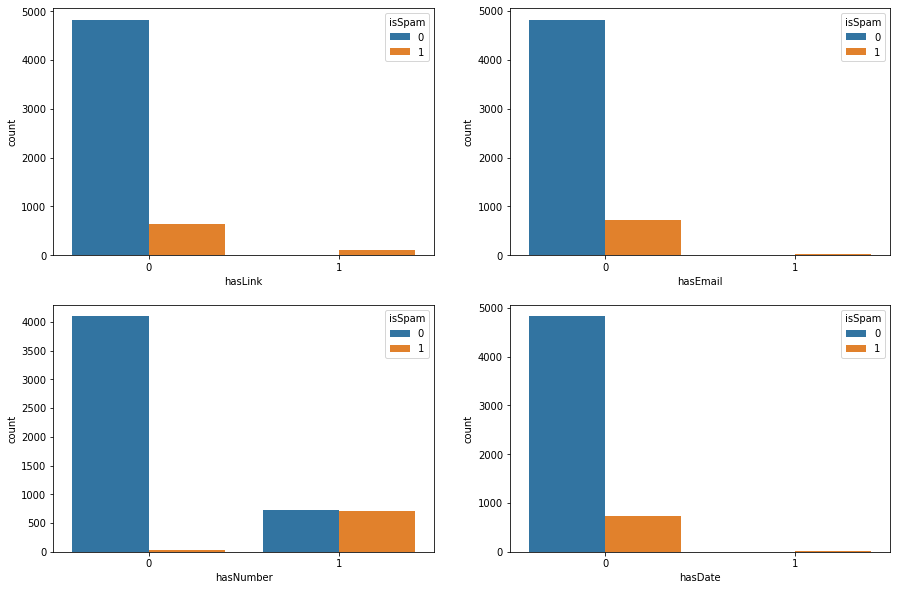

In [10]:
#------- EXPLORATORY PLOT -----
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(ax=axes[0][0], x='hasLink', data=data, hue='isSpam')
sns.countplot(ax=axes[0][1], x='hasEmail', data=data, hue='isSpam')
sns.countplot(ax=axes[1][0], x='hasNumber', data=data, hue='isSpam')
sns.countplot(ax=axes[1][1], x='hasDate', data=data, hue='isSpam')

Let's just set it to a log scale to be sure we are not missing anything

[None]

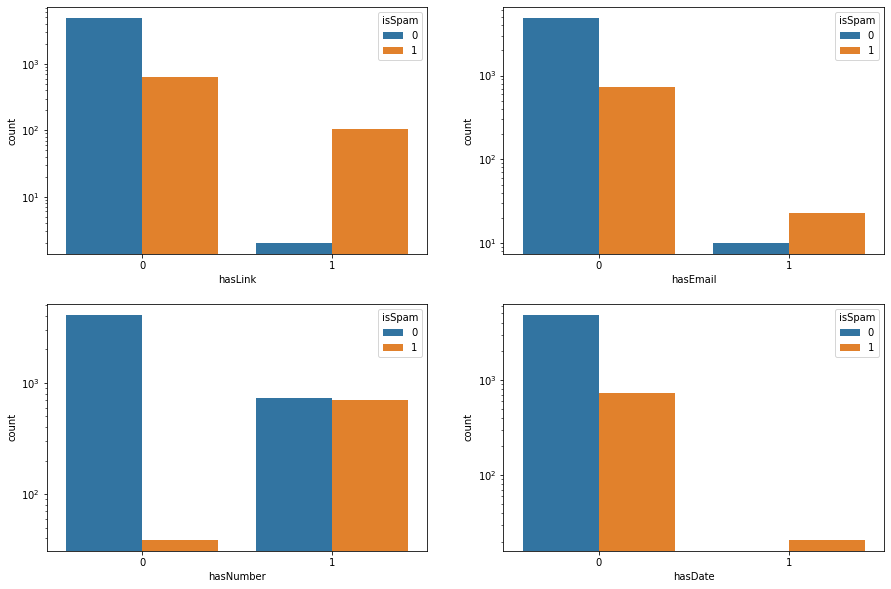

In [11]:
#------- EXPLORATORY PLOT -----
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(ax=axes[0][0], x='hasLink', data=data, hue='isSpam')
sns.countplot(ax=axes[0][1], x='hasEmail', data=data, hue='isSpam')
sns.countplot(ax=axes[1][0], x='hasNumber', data=data, hue='isSpam')
sns.countplot(ax=axes[1][1], x='hasDate', data=data, hue='isSpam')
axes[0][0].set(yscale="log")
axes[0][1].set(yscale="log")
axes[1][0].set(yscale="log")
axes[1][1].set(yscale="log")

From the 2 figures at the top we can see that if a message contains a link or an email it will mostly likely be an spam, but only a few number of spam messages compared to all of them contain a link or an email, so these informations may help but they will not be game changer. From the 2 plots at the bottom, the first interesting fact that we obtain is that 100% of the messages that contain a date in xx/xx format are spams. Again, the number of spam messages that contain a date is not enough when compared to the total spam messages that does not contain a data, but a great information that helps in the identification of a spam is that mostly of the spam messages have numbers. Let's now take a look at the 'hasMoney' variable.

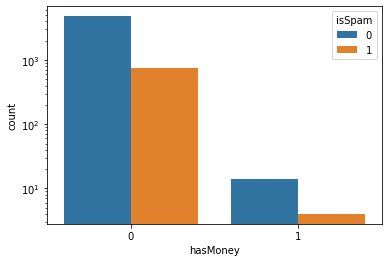

In [12]:
sns.countplot(x='hasMoney', data=data, hue='isSpam')
plt.yscale('log')

The money simbol ($) does not seems to play a big role in the identification, since the fraction of spam/ham in both hasMoney and has(not)Money are similar.

Let's not take a look at the length of the messages to check if there are valuable information in there:

<AxesSubplot:xlabel='len', ylabel='Count'>

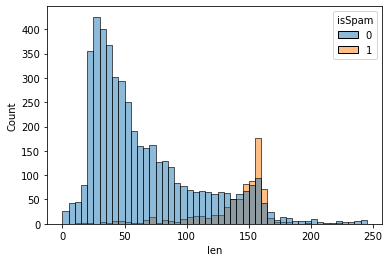

In [13]:
#--- Set Len
data['len'] = data['msg'].apply(lambda x:len(x))

sns.histplot(x='len',data=data,hue='isSpam',bins=range(0,250,5))

Well, it seems that the number of letters in the message can help us separate regions where we have a greater or smaller chance to get a spam. Let's start separating just in 4 regions:
1) from  0 - 80 letters
2) from 80 - 130 letters
3) from 130 - 165 letters
4) 165+ letters

In [14]:
#--- Set Len divisions
data['len80'] = data['msg'].apply(lambda x:1 if len(x)<80 else 0)
data['len130'] = data['msg'].apply(lambda x:1 if len(x)<130 else 0)
data['len165'] = data['msg'].apply(lambda x:1 if len(x)<165 else 0)
data['len165+'] = data['msg'].apply(lambda x:1 if len(x)>164 else 0)

Up to now we found 8 variables to try to identify spam messages: if contain numbers, a web link, an email, or a date, and 4 different regions of the number of letters. Let's now take a look at common words used in spam and ham messages that we can use to distinguish them.

In [15]:
#--- Create Dic
wordsSpam = data[data['v1'] == "spam"]['msg'].str.split(expand=True).stack().value_counts()
wordsHam = data[data['v1'] == "ham"]['msg'].str.split(expand=True).stack().value_counts()

In [16]:
wordsSpam.head(50)

to         682
a          373
call       342
your       263
you        252
the        204
for        201
or         188
free       180
2          169
is         152
ur         144
on         141
txt        136
have       135
from       127
and        122
u          117
text       112
mobile     109
with       108
claim      106
reply      101
&           98
of          95
now         93
4           93
stop        89
this        86
our         85
get         82
are         80
just        77
now!        70
in          69
new         69
only        66
send        65
nokia       64
won         64
prize       58
win         58
cash        56
contact     56
-           55
please      52
be          50
we          48
service     48
out         47
dtype: int64

In [17]:
wordsHam.head(50)

i       2140
you     1641
to      1508
the     1091
a       1035
u        858
and      831
in       771
my       725
is       688
me       575
of       506
for      486
that     432
it       427
have     423
but      406
your     404
are      399
so       386
on       374
not      369
i'm      367
at       365
can      352
do       338
if       332
will     325
be       319
we       291
get      286
just     282
2        279
when     269
with     267
how      242
up       240
what     233
go       232
ur       230
all      228
got      225
this     221
no       218
was      216
like     216
or       215
call     213
come     212
know     205
dtype: int64

Ok, so there are common words used in spam messages, such as: free, claim, reply, now, cash, prize, won, winner, and others! In the scope of the ham messages, sometimes they are more informal, using letters as 'r' instead of 'are', or 'u' instead of the word 'you'. Moreover, personal words such as 'i', 'me', 'he', 'she', 'we' are more common in ham messages. So let's use them in a dictionary for classification:

In [18]:
dicSpam = ["call","free","mobile","claim","reply","now","stop","only","nokia","won","prize","win","cash","contact","please","awarded","award",
			"i","r","u","ur","I'm","i'm","i'll","my","me","he","she","we","his","her","us"]
#The first line contain main words found in the spam messages
#The second line contain the main words found in the ham messages

Let's create then the classification for each message if it has or not each of these words from our dictionary. For this we should compare the full word to be sure that words such as 'won' will not return true if it find a word as 'wonderfull' and so on.

In [19]:
def hasWord(text,sub):
    for word in text:
       if sub == word:
          return 1
    return 0

for i in dicSpam:
    data[i] = data["splitMsg"].apply(lambda x:hasWord(x,i))

Now we can start to set up a model for our classifications. We can use the logistic regression with the informations that we have. For this we can just use all of the variables that we studied and use the dictionary words:

In [21]:
#------- SETTING MODEL -----
y = data['isSpam']
variables = ['hasEmail','hasLink','hasMoney','hasNumber','hasDate','len80','len130','len165','len165+']

The number of variables that we have so far are 9

In [22]:
len(variables)

9

Let's include the dictionary now

In [23]:
for i in dicSpam:
   variables.append(i)

The number of words used for classification are:

In [24]:
len(dicSpam)

32

So let's set the x variable with the 32 + 9 features and split the dataset

In [25]:
x = data[variables]
xT,xt,yT,yt = train_test_split(x,y,test_size=0.3,random_state=1)

And train the model

In [26]:
#------- TRAINING MODEL -----
logModel = LogisticRegression()
logModel.fit(xT,yT)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Let's check the predictions of the model in the classification

In [27]:
#------ MODEL PREDICTION -----
pred = logModel.predict(xt)
print('METRICS:')
print(metrics.classification_report(yt,pred))
print(metrics.confusion_matrix(yt,pred))

METRICS:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1436
           1       0.95      0.90      0.92       236

    accuracy                           0.98      1672
   macro avg       0.97      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[1425   11]
 [  24  212]]


Basically what we found was that if we use our trained model to this dataset we would have blocked 212 out of 236 spam messages, missing 24 of them. On the other hand, only 11 of the 1436 real ham messages would have been blocked. This means that:

In [29]:
print("Real ham messages misidentified as spam and blocked: " + str(11/1436*100) + "%")
print("Real spam messages blocked: " + str(24/236*100) + "%")

Real ham messages misidentified as spam and blocked: 0.766016713091922%
Real spam messages blocked: 10.16949152542373%


Almost 90% of spam messages would have been blocked, at the same time that less than 0.8% of real messages would have been blocked. The good thing here would be the balance of the higher spam messages blocked at the same time that the smaller number of real messages would be blocked. These are good results giving the simplicity of the approach used here.